# Finite Element Methode Anwendung für Jacobi und Gauss-Seidel - Verfahren

Das Notebook dient aus Ausblick auf weiterführende numerische Methoden (im Wahlmodul HANA werden solche Themen aufgegriffen).

Das Beispiel basiert auf der C++ FEM Bibliothek [NGSolve](http://ngsolve.org/).

Im Beispiel werden die iterativen Löser

- Jacobi - Verfahren
- Gauss-Seidel - Verfahren

für lineare Gleichungssysteme vorgestellt.

In [1]:
import netgen.geom2d as geom2d
from ngsolve import *
from ngsolve.webgui import Draw

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

## 2D Geometrie

Eine klassische Geometrie für numerische Versuche ist der sogennante *L-shaped domain*. Das Gebiet ist aufgrund eines einspringenden Eckens nicht konvex, was in vielen Anwendungen die Konsequenz hat, dass Regularität der Lösung beeinträchtigt wird (dh. wie oft ist die Lösung stetig differenzierbar).

In [4]:
geo = geom2d.SplineGeometry()
p1 = geo.AppendPoint (0,0)
p2 = geo.AppendPoint (1/2,0)
p3 = geo.AppendPoint (1/2,1/2)
p4 = geo.AppendPoint (1,1/2)
p5 = geo.AppendPoint (1,1)
p6 = geo.AppendPoint (0,1)

geo.Append (["line", p1, p2],bc='outer')
geo.Append (["line", p2, p3],bc='outer')
geo.Append (["line", p3, p4],bc='outer')
geo.Append (["line", p4, p5],bc='outer')
geo.Append (["line", p5, p6],bc='outer')
geo.Append (["line", p6, p1],bc='outer')

ngmesh = geo.GenerateMesh()
mesh = Mesh(ngmesh)

In [5]:
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2102-19-g7f1568e9a', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1,…

In [6]:
mesh.Refine()
mesh.Refine()
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2102-19-g7f1568e9a', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1,…

<div>
<img src=attachment:grafik.png width="300"/>
</div>
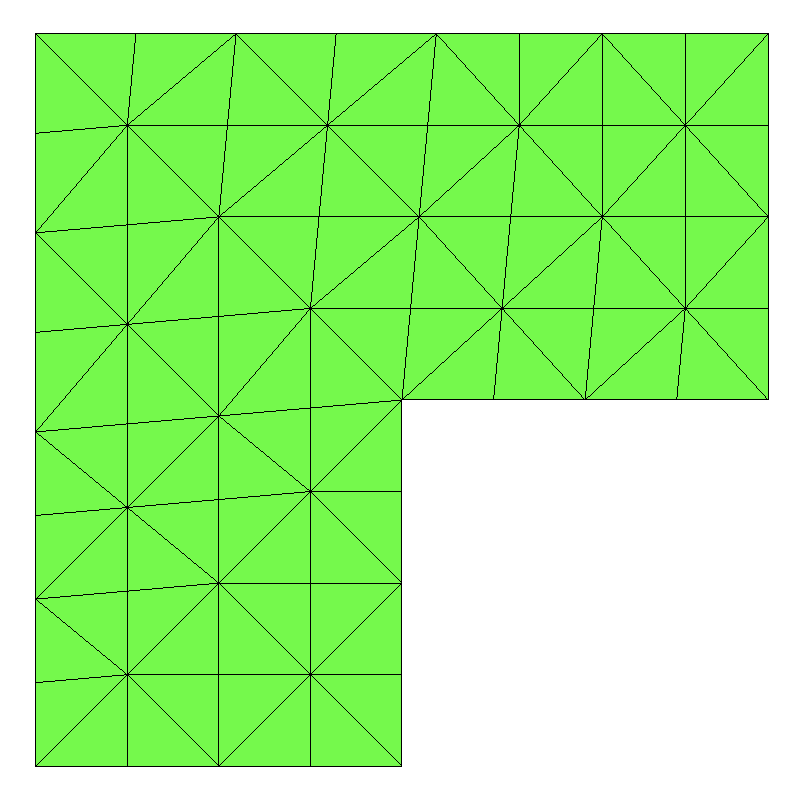

## FEM Diskretisierung

Wir berechnen das Notebook mit zwei verschiedenen Konfigurationen:

- **order = 1**
  Das heist, wir benutzen nur lineare Basisfunktionen.
  - In dem Fall konvergieren beide Verfahren (Jacobi und Gauss-Seidel)
- **order = 2 (>1)**
  Mit Hilfe von quadratisch oder höheren Basisfunktionen
  - In dem Fall konvergiert das Jacobi-Verfahren nicht mehr. Die System-Matrix genügt nicht mehr der Konvergenzbedingung.
  - Das Gauss-Seidel Verfahren funktioniert jedoch noch einwandfrei.

In [7]:
order = 1

In [8]:
fes = H1(mesh, order=order, dirichlet='outer')
u, v = fes.TnT()
print('ndof = ', fes.ndof)

ndof =  65


In [9]:
gfu = GridFunction(fes)

Visualisierung 1. FEM Basisfunktion 1. Ordnung, daher Polynome 1. Grades

<div>
<img src=attachment:grafik.png width="500"/>
</div>
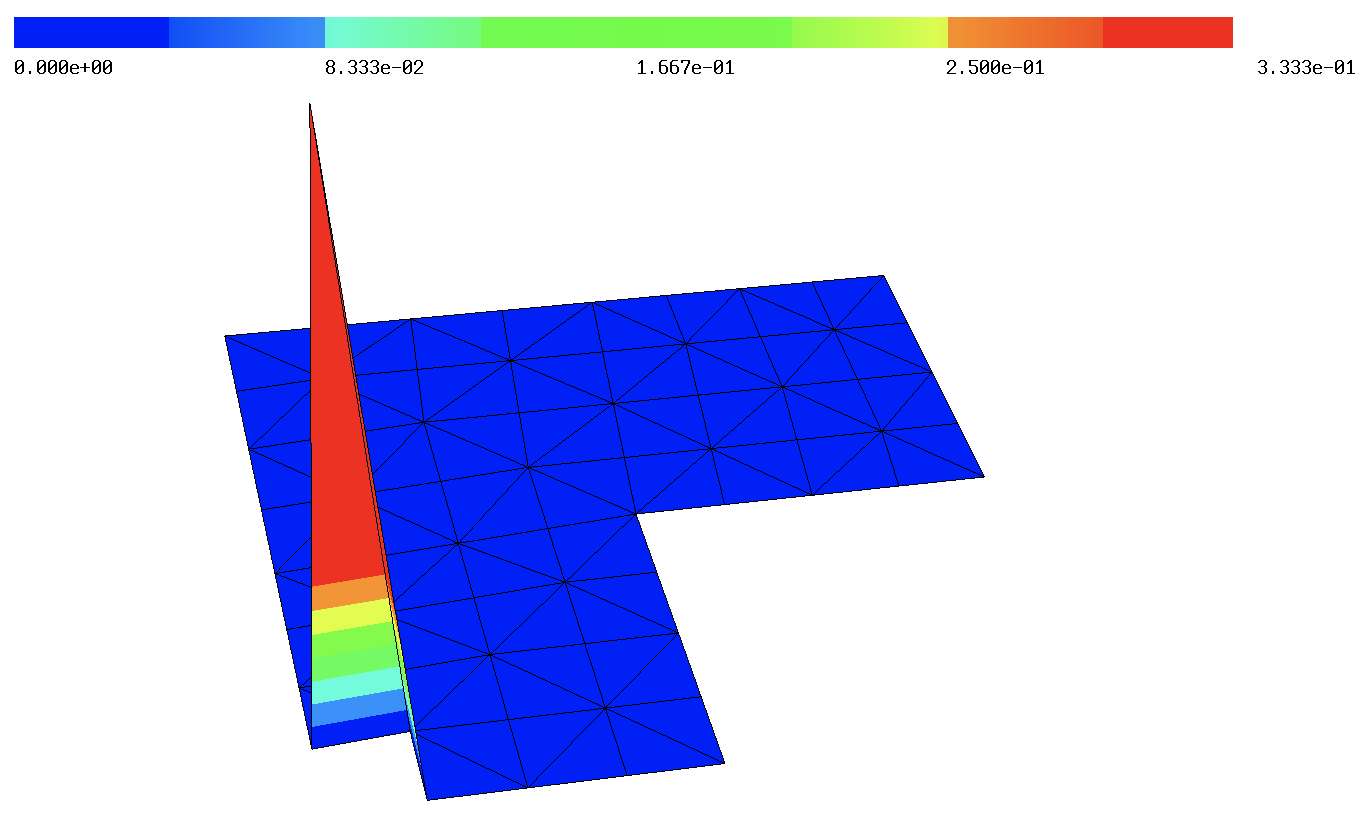

In [10]:
gfu.vec.FV()[10] = 1

In [11]:
Draw(gfu,mesh,'u')

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2102-19-g7f1568e9a', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

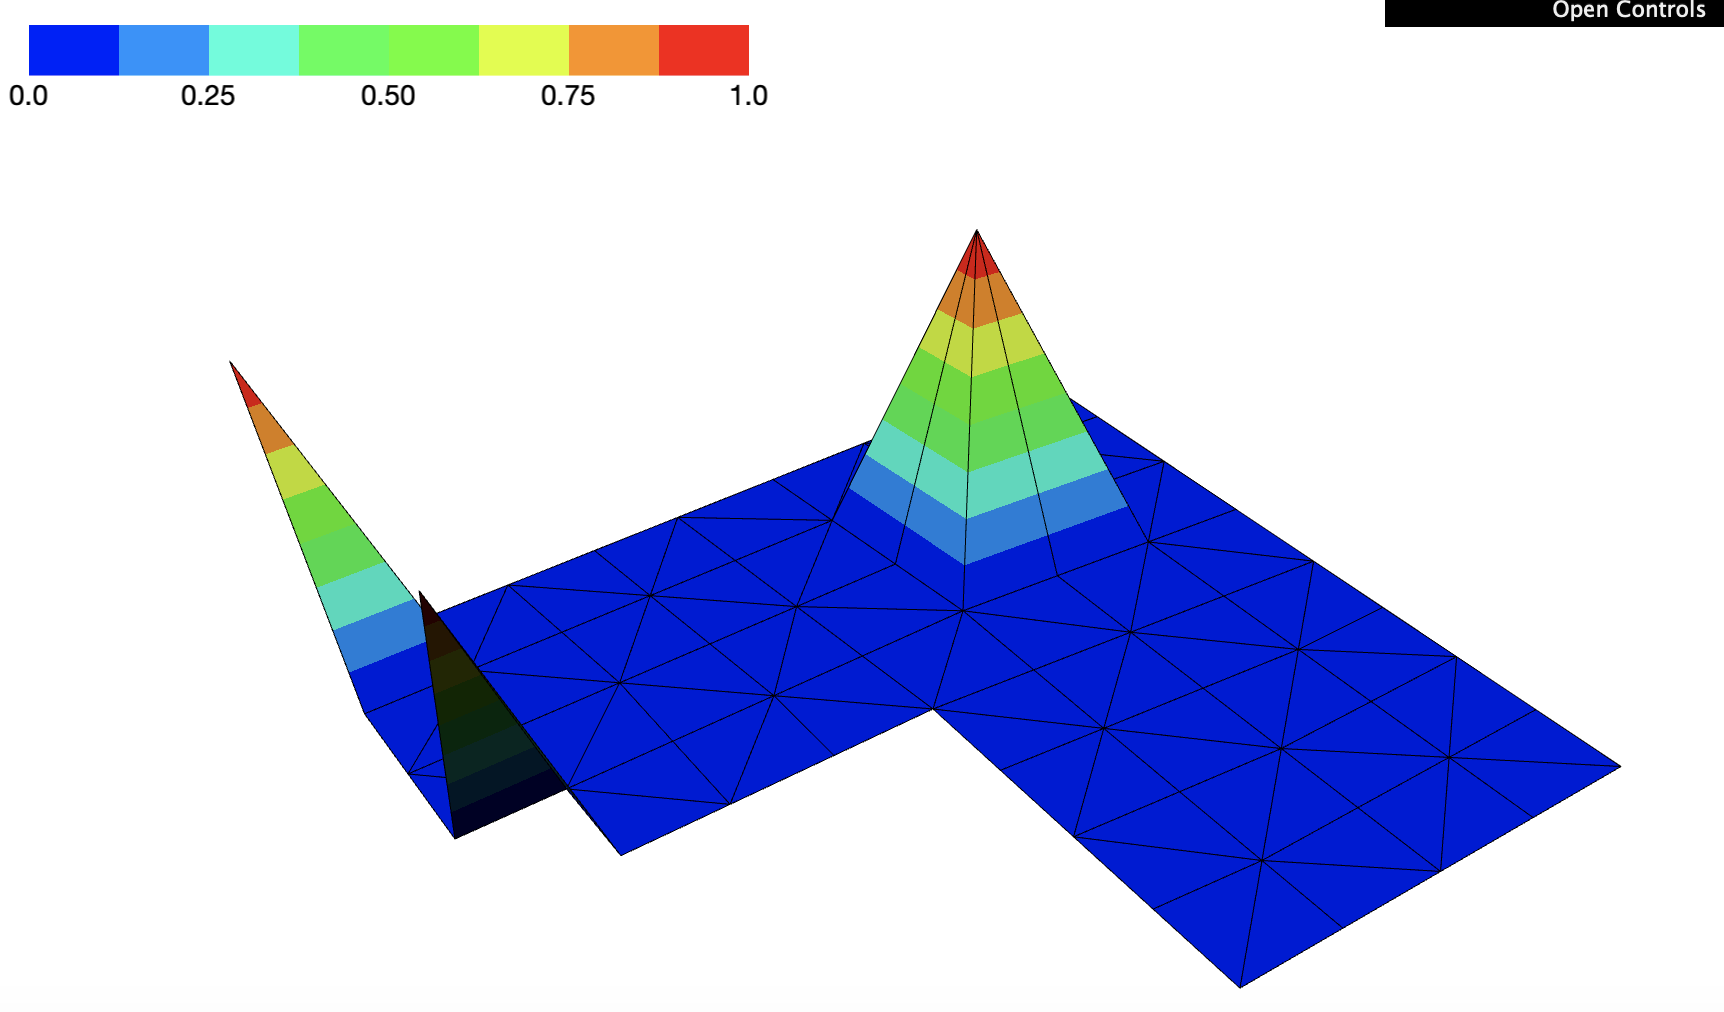

Matrix z.B. für Wärmeleitung

$$-\Delta u(x,y,z) = q(x,y,z)$$

analoge Verallgemeinerung der 1. Differentialgleichung

$$-u''(x) = q(x)$$

Für die Randbedingung nehmen wir homogene Dirichlet Randbedingung an. Daher für die Lösung gilt auf dem Rand $u=0$:
$$u(\Gamma) = 0.$$

Diskretisiert, dh. mit einer endlichen Anzahl Basisfunktionen, folgt das lineare Gleichungssystem

$$A\cdot u = f.$$

In [12]:
a = BilinearForm(fes)
a += grad(u)*grad(v)*dx

a.Assemble()

In [13]:
f = LinearForm(fes)
f += 10*v*dx

f.Assemble()

Im FEM Code ist die Matrix als dünnbesetzte (sparse) Matrix gespeichert.

In [13]:
rows,cols,vals = a.mat.COO()

In [14]:
A = sp.csr_matrix((vals,(rows,cols)))

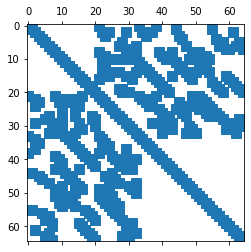

In [15]:
plt.spy(A)
plt.show()

Betrachte nur die freien Freiheitsgrade, dh. ohne Freiheitsgrade auf dem Rand:

In [16]:
ind = np.arange(0,fes.ndof)[np.array(fes.FreeDofs())]
print(ind)

[ 8  9 10 14 15 21 22 23 24 25 26 27 28 29 30 31 32 36 37 39 40 41 42 43
 47 48 49 50 51 52 53 54 59]


In [17]:
A

<65x65 sparse matrix of type '<class 'numpy.float64'>'
	with 385 stored elements in Compressed Sparse Row format>

In [18]:
65**2

4225

Der Einfachheit wegen, benutzen wir nun eine vollbesetzte Matrix. (Was man natürlich in der Praxis nicht machen würde):

In [19]:
B = []
for i in ind:
    B.append(A[i,ind].toarray()[0])
B = np.matrix(B)
B

matrix([[ 4.01661837,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  4.0184236 ,  0.        , ..., -1.10325656,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  4.02997533, ...,  0.        ,
         -0.92242727,  0.        ],
        ...,
        [ 0.        , -1.10325656,  0.        , ...,  4.01932808,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.92242727, ...,  0.        ,
          4.03203957,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  4.0305739 ]])

Rechte Seite für die freien Freiheitsgrade.

In [20]:
fi=f.vec.FV().NumPy()[ind]

Die diskrete FEM Lösung der partellen Differentialgleichung ist gegeben durch die Lösung des linearen Gleichungssystems

$$B\cdot u = f$$

Das System wird nun mit den beiden Verfahren im Vergleich gelöst.

### Jacobi Verfahren

Additive Zerlegung der vollbesetzten Matrix $B$
$$B = D-L-R$$

In [21]:
d = np.diag(B)
D=np.diag(d)
L = -np.tril(B,-1)
R = -np.triu(B,1)

Kontrolle:

In [22]:
np.linalg.norm(B-D+L+R,np.inf)

0.0

**Kontrolle**: $2D-B$ muss positiv definit sein

In [23]:
min(np.linalg.eigvals(2*D-B))

0.6065746969243466

Jacobi-Verfahren

$$D\cdot u_{k+1} = (L+R)\cdot u_k + b$$

In [24]:
u0 = np.ones_like(fi)

In [25]:
LR=L+R

In [26]:
u1 = u0

tol = 1e-14
nIter = 300
k=0
res = 1
while res > tol and k < nIter:
    u2 = (LR.dot(u1)+fi)/d # sehr schnell, da nur eine Matrix Multiplikation
    res = np.linalg.norm(u2-u1,ord=np.inf)
    u1 = u2
    k += 1
    print(k,res)    

1 0.4623395568427219
2 0.20894697354993874
3 0.14581905429998843
4 0.10427134839102636
5 0.08796066059054819
6 0.07390082493968464
7 0.0645655628700903
8 0.05629479691288519
9 0.04816904647814191
10 0.041744262201301896
11 0.035467215344990866
12 0.030525605181523807
13 0.025874051987301583
14 0.02214340740053322
15 0.01875850132572715
16 0.015983671972249758
17 0.013541958279954192
18 0.011500668494926203
19 0.009747289879043275
20 0.008257501476687579
21 0.007001524475260146
22 0.005920396592704269
23 0.005021972807222497
24 0.0042405929264732745
25 0.0035984413810953297
26 0.003035354734762241
27 0.0025765729491577516
28 0.002171655797589711
29 0.0018439514829060588
30 0.0015532257231091195
31 0.001319167311659708
32 0.001110668014623728
33 0.0009434940916211443
34 0.000794091932958152
35 0.000674683068944415
36 0.0005676956665418564
37 0.0004823973398002668
38 0.0004058201746827139
39 0.0003448824196931599
40 0.0002900917755961907
41 0.00024655296272124705
42 0.00020736155503819909

In [27]:
uset = np.zeros(fes.ndof)
uset[ind]=u2
gfu.vec.FV().NumPy()[:] = uset

In [28]:
Draw(gfu,mesh,'u')

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-67-g2f75ab1a8', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

Vergleich mit sparse Cholesky Solver:

In [29]:
gfu1 = GridFunction(fes)
gfu1.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs(),inverse='sparsecholesky')*f.vec

In [30]:
Draw(gfu1,mesh,'u1')

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-67-g2f75ab1a8', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2,…

<div>
<img src=attachment:grafik.png width="300"/>
</div>
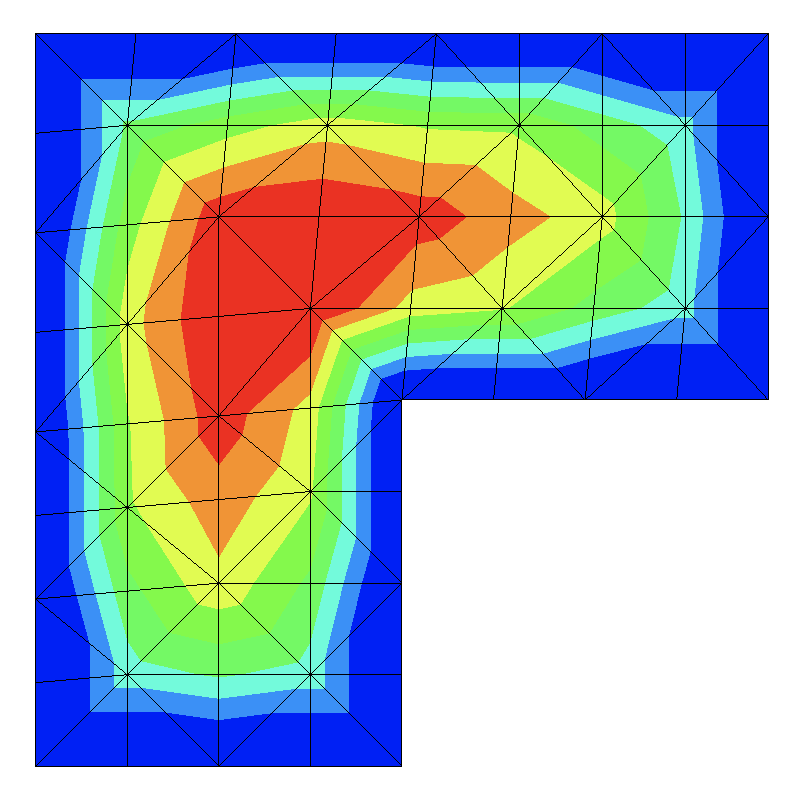

In [31]:
ufem = gfu1.vec.FV().NumPy()[ind]

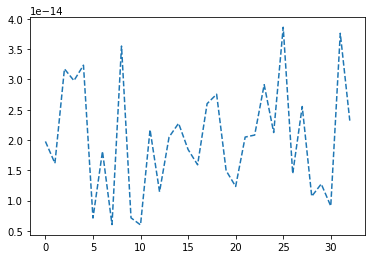

In [32]:
plt.plot(u2-ufem,'--')
plt.show()

### Gauss-Seidel Verfahren

Gauss-Seidel Verfahren

$$D\cdot u_{k+1} = L\cdot u_{k\color{red}+\color{red}1} + R\cdot u_k + b$$

Damit folgt:

$$(D-L)\cdot u_{k+1} = R\cdot u_k + b$$


In [33]:
DL = D-L

In [34]:
def forward(A, b):
    x = np.zeros_like(b) # Lösungsvektor
    x[0] = b[0]/A[0,0]
    for k in range(1,len(b)):
        x[k] = (b[k]-A[k,:k].dot(x[:k]))/A[k,k]
    return x

In [35]:
u1 = u0

tol = 1e-14
nIter = 300
k=0
res = 1
while res > tol and k < nIter:
    u2 = forward(DL,R.dot(u1)+fi)
    res = np.linalg.norm(u2-u1,ord=np.inf)
    u1 = u2
    k += 1
    print(k,res)

1 0.4617640583386501
2 0.3122143418744079
3 0.18366149241260532
4 0.11779585960680106
5 0.08867277978823018
6 0.06641312161397506
7 0.048772809847041465
8 0.03543837249387738
9 0.025588499051642455
10 0.01840393316927824
11 0.013202724688611
12 0.009455183585547589
13 0.00676343026030346
14 0.004834070599857743
15 0.0034531509772105506
16 0.0024657491513928598
17 0.0017602095637974657
18 0.0012563128792726919
19 0.0008965492930213537
20 0.000639750886972823
21 0.0004564783277971052
22 0.00032569453565517437
23 0.00023237411491827675
24 0.00016578915431364472
25 0.00011828193987850621
26 8.43872235185561e-05
27 6.020495864478281e-05
28 4.295226498313154e-05
29 3.064352784071245e-05
30 2.1862044369547196e-05
31 1.55970472752176e-05
32 1.1127402693267285e-05
33 7.938622402614559e-06
34 5.6636510446517185e-06
35 4.0406187778452285e-06
36 2.8826993039854365e-06
37 2.056605042599635e-06
38 1.4672446712604703e-06
39 1.0467772503797157e-06
40 7.468030715496177e-07
41 5.327923669473655e-07
42 3

In [36]:
uset = np.zeros(fes.ndof)
uset[ind]=u2
gfu.vec.FV().NumPy()[:] = uset

Vergleich mit sparse Cholesky Solver:

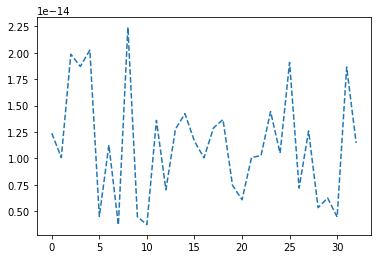

In [37]:
plt.plot(u2-ufem,'--')
plt.show()

Bemerkung: Die Matrix ist für FEM Ansatzfunktionen höherer Ordnung ($p\ge 2$) nicht mehr diagonal dominant. Das Jacobi-Verfahren konvergiert daher nicht. Das Gauss-Seidel Vefahren jedoch schon.